# Human Non-Speech Sound Classification
[INTRODUCTION TO THE PROBLEM HERE]

### Datasets
[DATASET DESCRIPTION HERE]


### Tasks
[TASK HERE]
- data augmentation techniques: Noise, Reverb, Delay, Low-pass filter 
- baseline models (XGBoost, Logistic regression)

### Integrants:
Name, Matricola, Email respectively
- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it
- Ivan Padezhki, 2041499, ivandragomirov.padezhki@studenti.unipd.it

## Dependencies

In [1]:
import os
import shutil
import urllib.request
import zipfile
import glob
import pandas as pd
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import librosa
import librosa.display

## Download Dataset

In [3]:
def download_dataset(name):
    """
    Download the dataset into current working directory.
    
    Originally taken from https://nbviewer.org/github/karoldvl/paper-2015-esc-dataset/blob/
    master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb#Setup
    Additional modifications were applied to make it work with Python 3
    """
    if not os.path.exists(name):
        os.mkdir(name)
        urllib.request.urlretrieve(f'https://github.com/karoldvl/{name}/archive/master.zip', f'{name}/{name}.zip')

        with zipfile.ZipFile(f'{name}/{name}.zip') as package:
            package.extractall(f'{name}/')

        os.unlink(f'{name}/{name}.zip')        

        for src in glob.glob(f'{name}/{name}-master/*'):
            shutil.move(src, '{0}/{1}'.format(name, os.path.basename(src)))

        shutil.rmtree(f'{name}/{name}-master')

download_dataset('ESC-50')

In [2]:
ls ESC-50

 Volume in drive C is Acer
 Volume Serial Number is D072-C241

 Directory of C:\Users\ivan_\Desktop\DS\third\hda\noisy-human-recognition\ESC-50

01/05/2023  04:34 PM    <DIR>          .
01/05/2023  04:34 PM    <DIR>          ..
01/05/2023  04:34 PM    <DIR>          audio
01/05/2023  04:34 PM           999,382 esc50.gif
01/05/2023  04:34 PM           284,523 LICENSE
01/05/2023  04:34 PM    <DIR>          meta
01/05/2023  04:34 PM                42 pytest.ini
01/05/2023  04:34 PM            29,720 README.md
01/05/2023  04:34 PM                45 requirements.txt
01/05/2023  04:34 PM    <DIR>          tests
               5 File(s)      1,313,712 bytes
               5 Dir(s)   3,399,528,448 bytes free


## Sample Dataset: Non-Speech Human Sounds

In this project we are going to fucus at identifying non-speech human sounds. Such as: `crying_baby`, `sneezing`, `clapping`, etc. So we are going to filter these categories from the main esc50 dataset.

In [2]:
esc50 = pd.read_csv("ESC-50/meta/esc50.csv")

human_cats = ['crying_baby', 'sneezing', 'clapping', 
              'breathing', 'coughing', 'footsteps', 
              'laughing', 'brushing_teeth', 'snoring', 
              'drinking_sipping']

esc50_human = esc50[esc50["category"].isin(human_cats)].reset_index(drop=True)

In [3]:
esc50_human.head()

,filename,fold,target,category,esc10,src_file,take
0,1-104089-A-22.wav,1,22,clapping,False,104089,A
1,1-104089-B-22.wav,1,22,clapping,False,104089,B
2,1-105224-A-22.wav,1,22,clapping,False,105224,A
3,1-110537-A-22.wav,1,22,clapping,False,110537,A
4,1-115920-A-22.wav,1,22,clapping,False,115920,A


## Exploratory Analysis

Let's start by looking at a single audio file of a baby crying.

In [7]:
def plot_example(filename):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    fig, axes = plt.subplots(3, 1)
    spf = wave.open("ESC-50/audio/" + filename, "r")
    category = esc50[esc50.filename == filename].category.values[0]

    # Extract Raw Audio from Wav File
    signal_raw = spf.readframes(-1)
    signal = np.frombuffer(signal_raw, "int16")

    axes[0].set_title(f"{category} - file: {filename}")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    axes[0].plot(np.arange(0, len(signal)) / RATE, signal)

    # Compute Melspectrogram Features
    signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
    signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
    signal = librosa.power_to_db(signal, ref=np.max)
    img = librosa.display.specshow(signal, x_axis='time', y_axis='linear', sr=RATE, cmap='RdBu_r', ax=axes[1])
    axes[1].set_title('Melspectrogram')
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Frequency(Hz)")
    
    # Compute MFCC
    mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)
    img = librosa.display.specshow(mfcc, x_axis='time',sr=RATE, cmap='RdBu_r', ax=axes[2])
    axes[2].set_title('MFCC')
    axes[2].set_ylabel("MFCC Coefficients")
    axes[2].set_xlabel("Time (s)")
    fig.tight_layout()
    plt.show()

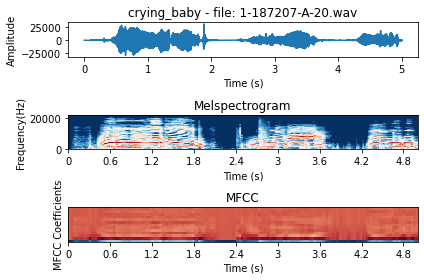

In [8]:
filename = "1-187207-A-20.wav"
plot_example(filename)
IPython.display.Audio("ESC-50/audio/" + filename)

Now, let's plot the amplitude and melspectrogram of one example per category.

In [9]:
def add_subplot_axes(ax, position):
    """
    Originally taken from https://nbviewer.org/github/karoldvl/paper-2015-esc-dataset/blob/
    master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb#Setup
    Additional modifications were applied to make it work with Python 3
    """
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]])

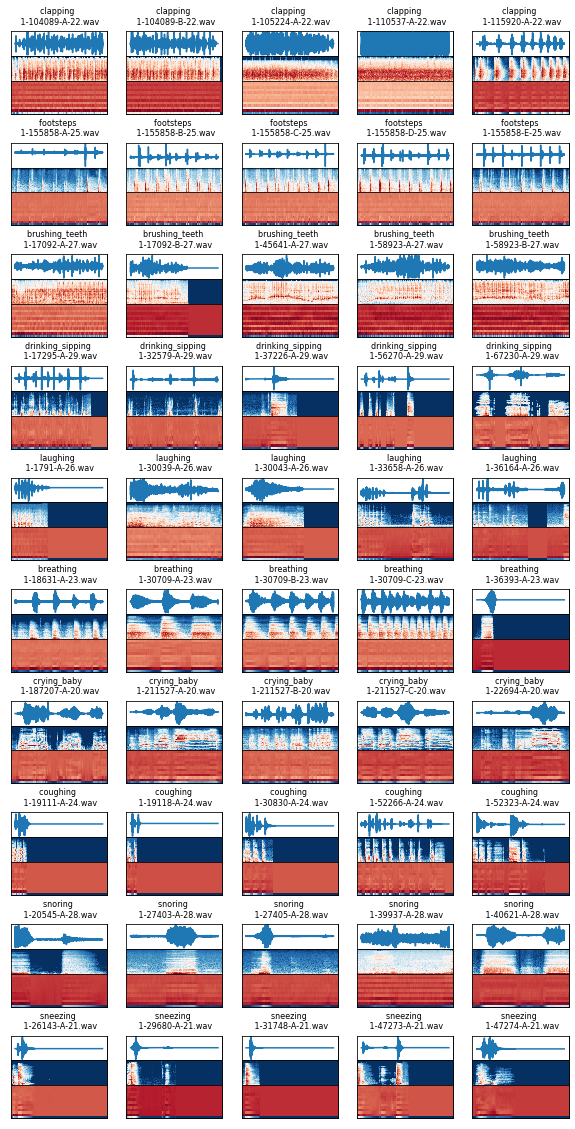

In [10]:
def plot_clip_overview(audio, category, filename ,ax):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3]) # [left, bottom, width, height]
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.4, 1.0, 0.3])
    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.4])
    
    # Extract Raw Audio from Wav File
    signal_raw = audio.readframes(-1)
    signal = np.frombuffer(signal_raw, "int16")
    ax_waveform.plot(np.arange(0, len(signal)) / float(RATE), signal)
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_waveform.set_title('{0} \n {1}'.format(category, filename), {'fontsize': 8}, y=1.03)

    # Compute Melspectrogram Features
    signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
    signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
    signal = librosa.power_to_db(signal, ref=np.max)
    librosa.display.specshow(signal, x_axis='time', y_axis='linear', sr=RATE, cmap='RdBu_r',ax=ax_spectrogram)
    ax_spectrogram.get_xaxis().set_visible(False)
    ax_spectrogram.get_yaxis().set_visible(False)
    
    # Compute MFCC
    mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time', sr=RATE, cmap='RdBu_r', ax=ax_mfcc)
    ax_mfcc.get_xaxis().set_visible(False)
    ax_mfcc.get_yaxis().set_visible(False)
    
categories = esc50_human.category.unique()
categories_len = len(categories)
clips_shown = 5
f, axes = plt.subplots(categories_len, clips_shown,
                       figsize=(clips_shown * 2, categories_len * 2), 
                       sharex=True, 
                       sharey=True)
f.subplots_adjust(hspace = 0.35)

for i, c in enumerate(categories):
    for j in range(0, clips_shown):
        filename = esc50_human[esc50_human.category == c].filename.iloc[j]
        spf = wave.open("ESC-50/audio/" + filename, "r")
        plot_clip_overview(spf, c, filename, axes[i, j])

TODO: We could do an EDA on the 13 MFCC coefficients per category

## Creating the MFCC dataset

In this section we will compute the MFCC coefficients for every sample in the `esc50_human` with the purpose of using is as input for machine learning classifiers.

In [4]:
def compute_features(df, is_augmentation=False):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    dataloader_dict = {}
    for i, row in df.iterrows():  
        filename = row["filename"]
        fold = int(row["fold"])
        target = row["target"]
        category = row["category"]

        spf = wave.open("ESC-50/audio/" + filename, "r")
        signal_raw = spf.readframes(-1)
        
        if is_augmentation:
            
            # draft of this part is at the end!
            
            # TODO: compute different data augmentations here on the raw_signal and then
            # compute the Melspectrogram and MFCC of the augmented data
            # others modifications to the code need to be implemented
            pass
        
        # Compute Melspectrogram Features
        signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
        signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
        signal = librosa.power_to_db(signal, ref=np.max)
        # Compute MFCC
        mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)

        dataloader_dict[i] = {"filename":filename, "data":mfcc, "target":target, "category":category,"fold":fold}
    return dataloader_dict

In [5]:
def train_loader(dic, fold):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if subj["fold"]!=fold:
            X_train.append(subj['data'])
            y_train.append(subj['target'])
                
        if subj["fold"]==fold:
            X_val.append(subj['data'])
            y_val.append(subj['target'])
    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

In [6]:
dataloader_dic = compute_features(esc50_human)
X_train, y_train, X_val, y_val = train_loader(dataloader_dic, fold=1)

`X_train` has a shape of `(320, 13, 431)` meaning that we have 320 examples of shape `(13, 431)` we can think about each example as an image of that size.

## Baseline models
In the following section we will trying some machine learning classifiers (eg: Random Forest, SVM, XGBoost) and then compare those results to much more complex models such a CNN.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
import xgboost as xgb

In [9]:
# reshape to 2 dimensions, as Random forest does not accept 3D input
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_val.shape
X_val_2d = X_val.reshape((nsamples,nx*ny))

### Random Forrest Classifier

In [11]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth':[5, 10, 15]
}

rand_forest = RandomForestClassifier(random_state=0)
clf = GridSearchCV(rand_forest, param_grid, cv = 5)
clf.fit(X_train_2d, y_train)

forest_acc = accuracy_score(clf.predict(X_val_2d), y_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10, 12, 15], 'n_estimators': [200, 400]})

In [16]:
forest_acc

0.4875

### SVM

In [18]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_grid = GridSearchCV(svm.SVC(random_state = 0), param_grid)
  
# fitting the model for grid search
svm_grid.fit(X_train_2d, y_train)

svm_acc = accuracy_score(svm_grid.predict(X_val_2d), y_val)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.094, total=   2.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.094, total=   2.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.094, total=   2.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.094, total=   2.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.094, total=   2.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.094, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.094, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.094, total=   2.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.094, total=   1.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.094, total=   1.6s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.094, total=   1.7s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.094, total=   1.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.094, total=   1.7s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.094, total=   1.7s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.094, total=   1.6s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.094, total=   1.7s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.094, total=   1.7s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.094, total=   1.7s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.328, total=   1.7s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.172, total=   1.7s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.250, total=   1.7s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.219, total=   1.6s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.156, total=   1.7s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  3.6min finished


In [19]:
svm_acc

0.4625

### XGBoost

In [34]:
y_train_0 = y_train-20
y_val_0 = y_val-20

In [39]:
xgb.__version__

'1.5.0'

In [40]:
param_grid = {
    'max_depth': [5, 10, 15]
}

boost = xgb.XGBClassifier(random_state=0)

xgb_grid = GridSearchCV(boost, param_grid)

xgb_grid.fit(X_train_2d, y_train)
xgb_acc = accuracy_score(xgb_grid.predict(X_val_2d), y_val)

C:\Users\ivan_\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:19] WARNI

In [42]:
xgb_acc

0.5

We additionally create a dataset containing augmented version of the raw input data. Following the augmentation techniques, the MFCC dataset is compiled for the larger sample and our model are ran on it. 

In [26]:
# still have a problem with running this here
from torchaudio_augmentations import *


def mfcc_computation(signal):
        # Compute Melspectrogram Features
        signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
        signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
        signal = librosa.power_to_db(signal, ref=np.max)
        # Compute MFCC
        mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)
        return mfcc

def augment_sound(signal):
    
    # create a noisy version of the input
    noisy = Noise(min_snr=0.04, max_snr=0.04)(signal)
    
    # add a reverb to the input
    reverbed = Reverb(
        sample_rate=sr,
        reverberance_min=90,
        reverberance_max=91,
        room_size_min=90,
        room_size_max=91,
    )(signal)
    
    # create a delayed version of the input - 200ms delay
    delayed = Delay(sample_rate=sr, min_delay=200, max_delay=201)(signal)
    
    # run a low-pass filter on the input data - cut off frequencies above 3000
    lowpassed = LowPassFilter(
        sample_rate=sr,
        p=1.0,
        min_cutoff_freq=3000,
        max_cutoff_freq=3001,
    )(signal.unsqueeze(0)).squeeze(0)
    
    return noisy, reverbed, delayed, lowpassed

RuntimeError: torchaudio.sox_effects.sox_effects.effect_names requires sox

In [ ]:
def compute_features(df, is_augmentation=False):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    dataloader_dict = {}
    dataloader_dict_noisy = {}
    dataloader_dict_reverbed = {}
    dataloader_dict_delayed = {}
    dataloader_dict_lowpass = {}
    
    for i, row in df.iterrows():  
        filename = row["filename"]
        fold = int(row["fold"])
        target = row["target"]
        category = row["category"]

        spf = wave.open("ESC-50/audio/" + filename, "r")
        signal_raw = spf.readframes(-1)
        
        if is_augmentation:
            
            signal_noisy, signal_rev, signal_delay, signal_low = augment_sound(signal_raw)
            mfcc_noisy = mfcc_computation(signal_noisy)
            dataloader_dict_noisy[i] = {'filename': filename, "data": mfcc_noisy, 
                                  "target": target, "category": category, 
                                 'fold': fold, "augmentation": "noisy"}
            
            mfcc_rev = mfcc_computation(signal_rev)
            dataloader_dict_reverbed[i] = {'filename': filename, "data": mfcc_rev, 
                                  "target": target, "category": category, 
                                 'fold': fold, "augmentation": "reverbed"}
            
            mfcc_delay = mfcc_computation(signal_delay)
            dataloader_dict_delayed[i] = {'filename': filename, "data": mfcc_delay, 
                                  "target": target, "category": category, 
                                 'fold': fold, "augmentation": "delayed"}
            
            mfcc_low = mfcc_computation(signal_low)
            dataloader_dict_lowpass[i] = {'filename': filename, "data": mfcc_low, 
                                  "target": target, "category": category, 
                                 'fold': fold, "augmentation": "low-pass"}
        
        # Compute Melspectrogram Features of non-augmented signal
        mfcc = mfcc_computation(signal)
        dataloader_dict[i] = {"filename":filename, "data_orig":mfcc, "target":target, "category":category,"fold":fold}
        
        
    return dataloader_dict, dataloader_dict_noisy, dataloader_dict_reverbed, dataloader_dict_delayed, dataloader_dict_lowpass

second idea

In [ ]:
def compute_features(df, is_augmentation=False):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    dataloader_dict = {}
    dataloader_dict_noisy = {}
    dataloader_dict_reverbed = {}
    dataloader_dict_delayed = {}
    dataloader_dict_lowpass = {}
    
    for i, row in df.iterrows():  
        filename = row["filename"]
        fold = int(row["fold"])
        target = row["target"]
        category = row["category"]

        spf = wave.open("ESC-50/audio/" + filename, "r")
        signal_raw = spf.readframes(-1)
        
        if is_augmentation:
            
            signal_noisy, signal_rev, signal_delay, signal_low = augment_sound(signal_raw)
            
            mfcc_noisy = mfcc_computation(signal_noisy)
            mfcc_rev = mfcc_computation(signal_rev)
            mfcc_delay = mfcc_computation(signal_delay)
            mfcc_low = mfcc_computation(signal_low)
        
        # Compute Melspectrogram Features of non-augmented signal
        mfcc = mfcc_computation(signal)
        dataloader_dict[i] = {"filename":filename, "data_orig":mfcc, 
                              "data_noisy": mfcc_noisy, "data_rev": mfcc_rev
                              "data_low": mfcc_low, "data_delayed": mfcc_delay, 
                              "target":target, "category":category,"fold":fold}
        
        
    return dataloader_dict